# Causal Discovery Experiments of PC vs PC-with-sorting

In the PCMCI paper, Runge et al. proposes the improvement of a PC-based algorithm for time-series, which improves the skeleton discovery stage to estimate a good superset of parents. This superset of parents is then used in a second stage of the algorithm, known as the Momentary Conditional Independence (MCI) condition.

In [6]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from pathlib import Path
from pprint import pprint

import numpy as np
import bnlearn as bn
import networkx as nx

import causal_networkx
from causal_networkx.ci import (
    g_square_discrete,
    fisherz,
    g_square_binary,
    Oracle,
    ParentOracle,
)
from causal_networkx.discovery import PC, RobustPC
from causal_networkx.io import load_from_pgmpy

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import logging

logging.basicConfig(level=logging.INFO)

In [10]:
np.random.seed(12345)

# Load sample graphs using bnlearn

bnlearn is a package providing sample graphs. It was originally written in R and the Python interface now provides much of the same functionality.

## Discrete data

We'll start out first analyzing discrete data with relatively simple structure.

For the Asia graph: https://www.bnlearn.com/documentation/man/asia.html Here, we're interested in determining the causes of "shortness-of-breath" (i.e. dyspnoea). Bnlearn provides the ground-truth DAG and also a dataset.

In [11]:
# Load data
df = bn.import_example(data="asia")

[bnlearn] >Downloading example [asia] dataset..
100% [..........................................................................] 5373 / 5373[bnlearn] >Extracting files..


  0%|          | 0/8 [00:00<?, ?it/s]

[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </Users/adam2392/miniconda3/envs/causalx64_2/lib/python3.9/site-packages/bnlearn/data/asia.bif>
[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


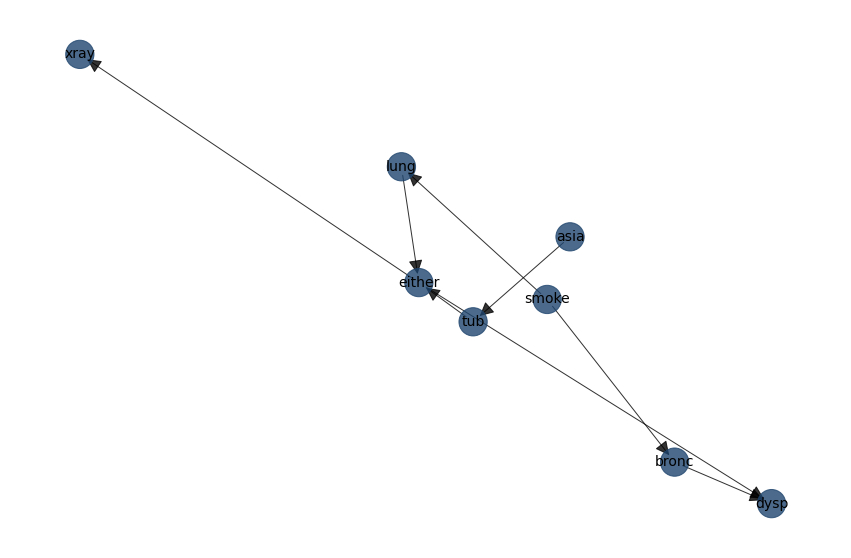

Plotting the ground-truth DAG


In [12]:
# load the graph
DAG = bn.import_DAG("asia")

# plot ground truth
G = bn.plot(DAG)
print("Plotting the ground-truth DAG")

In [13]:
display(df.head())
print(df.shape)

,asia,tub,smoke,lung,bronc,either,xray,dysp
0,1,1,1,1,1,1,1,1
1,1,1,0,1,0,1,1,0
2,1,1,0,1,0,1,1,0
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1


(10000, 8)


In [14]:
for col in df.columns:
    print(df[col].unique())

[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]


In [11]:
pos = {
    "asia": [-2.005, -1.230],
    "bronc": [1.166, -0.501],
    "dysp": [0.852, 0.635],
    "either": [-0.914, 0.234],
    "lung": [-0.420, -0.701],
    "smoke": [0.695, -1.292],
    "tub": [-2.013, -0.690],
    "xray": [-0.899, 0.797],
}
pos = {node: [val[0], val[1] * -1] for node, val in pos.items()}

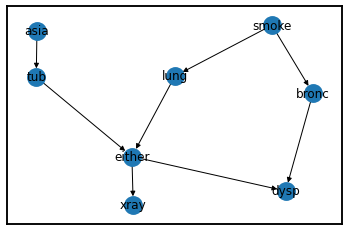

In [23]:
# convert the true causal graph from PGMPY
true_dag = load_from_pgmpy(DAG)

true_dag.draw(pos=pos)

# Apply the normal PC Algorithm

In [15]:
ci_estimator = g_square_binary
# ci_estimator = fisherz
alpha = 0.001

pcalg = PC(
    ci_estimator=ci_estimator,
    alpha=alpha,
    # max_combinations=1,
    # apply_orientations=False,
)

In [16]:
pcalg.fit(df)

INFO:root:Did not remove edge asia-tub conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.0002772802681166313
INFO:root:Removing edge asia-smoke conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.06868808243213675
INFO:root:Removing edge asia-lung conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.46010784522789583
INFO:root:Removing edge asia-bronc conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.05846733566927866
INFO:root:Removing edge asia-either conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.011128783199904617
INFO:root:Removing edge asia-xray conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.0944523061350099
INFO:root:Removing edge asia-dysp conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.02968556523585184
INFO:root:Removed all edges with p = 0
INFO:root:Did not remove edge tub-asia conditioned on set(): MCI=No MCI, alpha=0.001, pvalue=0.0002772802681166313
INFO:root:Removing edge tub-smoke conditioned on set(): MCI=No MCI, alpha=0.001

In [17]:
graph = pcalg.graph_
sep_set = pcalg.separating_sets_

print(graph)

CPDAG with 8 nodes, 2 edges and 3 undirected edges


[Text(0.5, 1.0, 'Asia graph with PC alg: alpha=0.001')]

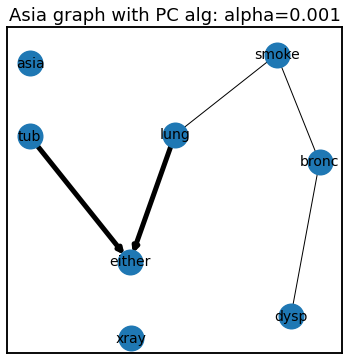

In [19]:
sns.set_context(context="talk")
font_size = 14
node_size = 600
edgewidth = 5
pos = {
    "asia": [-2.005, -1.230],
    "bronc": [1.166, -0.501],
    "dysp": [0.852, 0.635],
    "either": [-0.914, 0.234],
    "lung": [-0.420, -0.701],
    "smoke": [0.695, -1.292],
    "tub": [-2.013, -0.690],
    "xray": [-0.899, 0.797],
}
pos = {node: [val[0], val[1] * -1] for node, val in pos.items()}
# pos = nx.rescale_layout(
#     # graph.dag, seed=12,
#     pos=pos)
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_labels(graph.dag, pos, ax=ax, font_size=font_size)
nx.draw_networkx_nodes(graph.dag, pos, ax=ax, node_size=node_size)

nx.draw_networkx_edges(graph.dag, pos, ax=ax, width=edgewidth)
nx.draw_networkx_edges(graph.undirected_edge_graph, pos, ax=ax)

ax.set(
    title=f"Asia graph with PC alg: alpha={alpha}",
)
# fig.savefig(
#     f"/Users/adam2392/Downloads/asia_with_pc_alpha{alpha}.pdf",
#     bbox_inches="tight",
# )

In [20]:
pprint(sep_set)

defaultdict(<function ConstraintDiscovery._initialize_graph.<locals>.<lambda> at 0x19ff3a310>,
            {'asia': defaultdict(<class 'set'>,
                                 {'bronc': set(),
                                  'dysp': set(),
                                  'either': set(),
                                  'lung': set(),
                                  'smoke': set(),
                                  'tub': {'either'},
                                  'xray': set()}),
             'bronc': defaultdict(<class 'set'>,
                                  {'asia': set(),
                                   'either': {'smoke'},
                                   'lung': {'smoke'},
                                   'tub': set(),
                                   'xray': {'smoke'}}),
             'dysp': defaultdict(<class 'set'>,
                                 {'asia': set(),
                                  'either': {'tub', 'lung'},
                                

# Apply the Robust PC Algorithm with MCI conditioning

In [24]:
ci_estimator = g_square_binary
# ci_estimator = fisherz
alpha = 0.1
max_conds_x = None
max_conds_y = None
mci_alpha = 0.05

robust_pcalg = RobustPC(
    ci_estimator=ci_estimator,
    alpha=alpha,
    max_combinations=1,
    max_conds_x=max_conds_x,
    max_conds_y=max_conds_y,
    mci_alpha=mci_alpha
    # apply_orientations=False,
)

In [25]:
robust_pcalg.fit(df)

INFO:root:Did not remove edge asia-tub conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.0002772802681166313
INFO:root:Did not remove edge asia-smoke conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.06868808243213675
INFO:root:Removing edge asia-lung conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.46010784522789583
INFO:root:Did not remove edge asia-bronc conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.05846733566927866
INFO:root:Did not remove edge asia-either conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.011128783199904617
INFO:root:Did not remove edge asia-xray conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.0944523061350099
INFO:root:Did not remove edge asia-dysp conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.02968556523585184
INFO:root:Removed all edges with p = 0
INFO:root:Did not remove edge asia-tub conditioned on {'smoke'}: MCI=No MCI, alpha=0.1, pvalue=5.5840314494393764e-05
INFO:root:Did not remove edge asia-smoke conditioned on {'tu

In [111]:
test_stat, pvalue = robust_pcalg.test_edge(
    df,
    "either",
    "dysp",
    # "xray",
    [
        "tub",
        "lung",
        # "either",
        # "bronc",
    ],
)

print(f"Pvalue={pvalue} for either-dysp conditioned on lung and tub")
# print(f"Pvalue={pvalue} for xray-dysp conditioned on either,bronc")

Pvalue=1.0 for either-dysp conditioned on lung and tub


In [26]:
graph = robust_pcalg.graph_
sep_set = robust_pcalg.separating_sets_
def_parents = robust_pcalg.def_parents_

print(graph)

CPDAG with 8 nodes, 4 edges and 3 undirected edges


[Text(0.5, 1.0, 'RobustPC alg: alpha=0.1, MCI-alpha=0.05')]

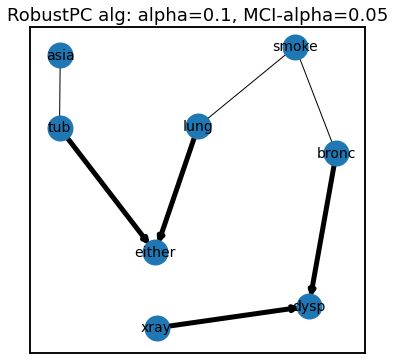

In [27]:
font_size = 14
node_size = 600
edgewidth = 5
# pos = nx.spring_layout(graph.dag, seed=5)
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_labels(graph.dag, pos, ax=ax, font_size=font_size)
nx.draw_networkx_nodes(graph.dag, pos, ax=ax, node_size=node_size)

nx.draw_networkx_edges(graph.dag, pos, ax=ax, width=edgewidth)
nx.draw_networkx_edges(graph.undirected_edge_graph, pos, ax=ax)

ax.set(
    title=f"RobustPC alg: alpha={alpha}, MCI-alpha={mci_alpha}",
)
# fig.savefig(
#     f"/Users/adam2392/Downloads/asia_with_robustpc_alpha{alpha}_mcialpha{mci_alpha}.pdf",
#     bbox_inches="tight",
# )

In [66]:
pprint(def_parents)

{'asia': [],
 'bronc': [],
 'dysp': [],
 'either': ['tub', 'lung'],
 'lung': [],
 'smoke': [],
 'tub': [],
 'xray': []}


In [67]:
pprint(sep_set)

defaultdict(<function ConstraintDiscovery._initialize_graph.<locals>.<lambda> at 0x7fa43655fa60>,
            {'asia': defaultdict(<class 'set'>,
                                 {'bronc': set(),
                                  'dysp': {'tub'},
                                  'either': {'tub', 'lung'},
                                  'lung': set(),
                                  'smoke': set(),
                                  'xray': set()}),
             'bronc': defaultdict(<class 'set'>,
                                  {'asia': set(),
                                   'either': {'tub', 'lung'},
                                   'lung': {'smoke'},
                                   'tub': set(),
                                   'xray': {'smoke', 'tub'}}),
             'dysp': defaultdict(<class 'set'>,
                                 {'asia': {'tub'},
                                  'either': {'tub', 'lung'},
                                  'lung': {'either', 's

# RobustPC Algorithm with Known Oracle Parents

In [43]:
ci_estimator = g_square_binary
partial_knowledge = ParentOracle(true_dag)

# ci_estimator = fisherz
alpha = 0.1
max_conds_x = None
max_conds_y = None
mci_alpha = 0.05
size_inclusive = True
max_cond_set_size = None

robust_pcalg = RobustPC(
    ci_estimator=ci_estimator,
    max_cond_set_size=max_cond_set_size,
    alpha=alpha,
    max_combinations=None,
    max_conds_x=max_conds_x,
    max_conds_y=max_conds_y,
    mci_alpha=mci_alpha,
    partial_knowledge=partial_knowledge,
    size_inclusive=size_inclusive,
    # apply_orientations=False,
)

In [44]:
robust_pcalg.fit(df)

INFO:root:Did not remove edge asia-tub conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.0002772802681166313
INFO:root:Did not remove edge asia-smoke conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.06868808243213675
INFO:root:Removing edge asia-lung conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.46010784522789583
INFO:root:Did not remove edge asia-bronc conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.05846733566927866
INFO:root:Did not remove edge asia-either conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.011128783199904617
INFO:root:Did not remove edge asia-xray conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.0944523061350099
INFO:root:Did not remove edge asia-dysp conditioned on set(): MCI=No MCI, alpha=0.1, pvalue=0.02968556523585184
INFO:root:Removed all edges with p = 0
INFO:root:Did not remove edge asia-tub conditioned on {'smoke'}: MCI=No MCI, alpha=0.1, pvalue=5.5840314494393764e-05
INFO:root:Did not remove edge asia-tub conditioned on {'bron

{'asia': {}, 'tub': {'asia': inf}, 'smoke': {}, 'lung': {'smoke': inf}, 'bronc': {'smoke': inf}, 'either': {'tub': inf, 'lung': inf}, 'xray': {'either': inf}, 'dysp': {'bronc': inf, 'either': inf}}


In [45]:
graph = robust_pcalg.graph_
sep_set = robust_pcalg.separating_sets_
def_parents = robust_pcalg.def_parents_

print(graph)

CPDAG with 8 nodes, 12 edges and 15 undirected edges


In [46]:
print(robust_pcalg._inter_test_stat_dict)

{'asia': {}, 'tub': {'asia': inf}, 'smoke': {}, 'lung': {'smoke': inf}, 'bronc': {'smoke': inf}, 'either': {'tub': inf, 'lung': inf}, 'xray': {'either': inf}, 'dysp': {'bronc': inf, 'either': inf}}


[Text(0.5, 1.0, 'RobustPC alg: alpha=0.1, MCI-alpha=0.05')]

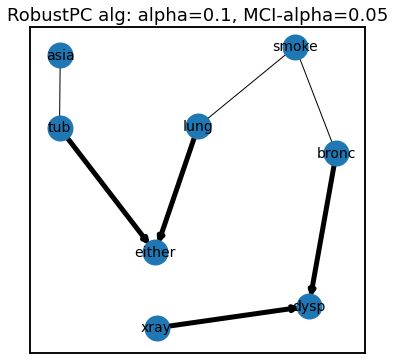

In [31]:
font_size = 14
node_size = 600
edgewidth = 5
# pos = nx.spring_layout(graph.dag, seed=5)
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_labels(graph.dag, pos, ax=ax, font_size=font_size)
nx.draw_networkx_nodes(graph.dag, pos, ax=ax, node_size=node_size)

nx.draw_networkx_edges(graph.dag, pos, ax=ax, width=edgewidth)
nx.draw_networkx_edges(graph.undirected_edge_graph, pos, ax=ax)

ax.set(
    title=f"RobustPC alg: alpha={alpha}, MCI-alpha={mci_alpha}",
)
# fig.savefig(
#     f"/Users/adam2392/Downloads/parent_oracle_asia_with_robustpc_alpha{alpha}_mcialpha{mci_alpha}_maxcondsize{max_cond_set_size}.pdf",
#     bbox_inches="tight",
# )

In [34]:
cond_set = [
    "bronc",
    "asia",
    # "lung",
    "either",
    # "bronc",
]
x = "tub"
y = "dysp"
test_stat, pvalue = robust_pcalg.test_edge(
    df,
    x,
    y,
    # "xray",
    cond_set,
)

print(f"Pvalue={pvalue} for {x}-{y} conditioned on {cond_set}")
# print(f"Pvalue={pvalue} for xray-dysp conditioned on either,bronc")

Pvalue=0.9856758255784772 for tub-dysp conditioned on ['bronc', 'asia', 'either']


# RobustPC Algorithm with Known Oracle Parents and Children

In [71]:
ci_estimator = g_square_binary
partial_knowledge = ParentOracle(true_dag)

# ci_estimator = fisherz
alpha = 0.1
max_conds_x = None
max_conds_y = None
mci_alpha = 0.05
size_inclusive = False
max_cond_set_size = None

robust_pcalg = RobustPC(
    ci_estimator=ci_estimator,
    max_cond_set_size=max_cond_set_size,
    alpha=alpha,
    max_combinations=None,
    max_conds_x=max_conds_x,
    max_conds_y=max_conds_y,
    mci_alpha=mci_alpha,
    partial_knowledge=partial_knowledge,
    size_inclusive=size_inclusive,
    use_children=False,
    skip_first_stage=True,
    only_mci=True,
    # apply_orientations=False,
)

In [72]:
robust_pcalg.fit(df)

INFO:root:set(), {'asia'}
INFO:root:Did not remove edge asia-tub conditioned on (): MCI=set(), alpha=0.05, pvalue=0.0002772802681166313
INFO:root:set(), set()
INFO:root:Removing edge asia-smoke conditioned on (): MCI=set(), alpha=0.05, pvalue=0.06868808243213675
INFO:root:set(), {'smoke'}
INFO:root:Removing edge asia-lung conditioned on (): MCI={'smoke'}, alpha=0.05, pvalue=0.46010784522789583
INFO:root:set(), {'smoke'}
INFO:root:Removing edge asia-bronc conditioned on (): MCI={'smoke'}, alpha=0.05, pvalue=0.05846733566927866
INFO:root:set(), {'tub', 'lung'}
INFO:root:Did not remove edge asia-either conditioned on (): MCI={'tub', 'lung'}, alpha=0.05, pvalue=0.011128783199904617
INFO:root:set(), {'either'}
INFO:root:Removing edge asia-xray conditioned on (): MCI={'either'}, alpha=0.05, pvalue=0.0944523061350099
INFO:root:set(), {'bronc', 'either'}
INFO:root:Did not remove edge asia-dysp conditioned on (): MCI={'bronc', 'either'}, alpha=0.05, pvalue=0.02968556523585184
INFO:root:Removed 

In [73]:
graph = robust_pcalg.graph_
sep_set = robust_pcalg.separating_sets_
def_parents = robust_pcalg.def_parents_
def_children = robust_pcalg.def_children_
print(graph)

CPDAG with 8 nodes, 6 edges and 2 undirected edges


In [74]:
print(robust_pcalg._inter_test_stat_dict)

{'asia': {}, 'tub': {'asia': inf}, 'smoke': {}, 'lung': {'smoke': inf}, 'bronc': {'smoke': inf}, 'either': {'tub': inf, 'lung': inf}, 'xray': {'either': inf}, 'dysp': {'bronc': inf, 'either': inf}}


In [16]:
print(robust_pcalg._inter_test_stat_dict)

{'asia': {}, 'tub': {'asia': inf}, 'smoke': {}, 'lung': {'smoke': inf}, 'bronc': {'smoke': inf}, 'either': {'tub': inf, 'lung': inf}, 'xray': {'either': inf}, 'dysp': {'bronc': inf, 'either': inf}}


[Text(0.5, 1.0, 'RobustPC alg: alpha=0.1, MCI-alpha=0.05')]

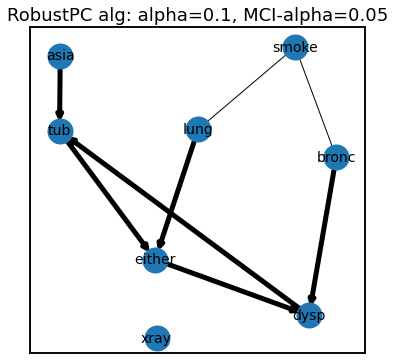

In [75]:
font_size = 14
node_size = 600
edgewidth = 5
# pos = nx.spring_layout(graph.dag, seed=5)
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_labels(graph.dag, pos, ax=ax, font_size=font_size)
nx.draw_networkx_nodes(graph.dag, pos, ax=ax, node_size=node_size)

nx.draw_networkx_edges(graph.dag, pos, ax=ax, width=edgewidth)
nx.draw_networkx_edges(graph.undirected_edge_graph, pos, ax=ax)

ax.set(
    title=f"RobustPC alg: alpha={alpha}, MCI-alpha={mci_alpha}",
)
# fig.savefig(
#     f"/Users/adam2392/Downloads/parent_oracle_asia_with_robustpc_alpha{alpha}_mcialpha{mci_alpha}_maxcondsize{max_cond_set_size}.pdf",
#     bbox_inches="tight",
# )